# Forward Curves in QuantLib

For forward curves there are two main objects: `FlatForward` and `ForwardCurve`.

`FlatForward` is just simply a flat forward (which also means flat spot) curve, taking a single `ql.QuoteHandle(ql.SimpleQuote(rate))` on the input and a single day as of which this flat curve starts. 

(**Note**: Alternatively, we don't provide the starting date but we use `ql.Settings.instance().evaluationDate = ql.Date(.,.,.)`)

`ForwardCurve` is a more general object taking a set of observed forward rates. It does **not** use `ql.Settings.instance().evaluationDate` but instead it uses the first date as the starting date.

In [13]:
import QuantLib as ql
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%config InlineBackend.figure_format='retina'

# conversion of python date to QuantLib date
def dt_to_ql_Date(dt): return ql.Date(dt.day, dt.month, dt.year)

# `FlatForward`
This object represets a flat curve.

Two possible formulations are available: i) via explicit start date, or ii) via `today`.

**Note**: It is assumed that the input fwd rate is under _continuous componding_, unless stated otherwise in the constructor.

In [9]:

# option I): explicit start date of the fwd curve
print(ql.FlatForward(ql.Date(15,6,2020), ql.QuoteHandle(ql.SimpleQuote(0.05)), ql.Actual360()).zeroRate(ql.Date(15,6,2020), ql.Actual360(), ql.Continuous).rate())


# option II): via setting today date
ql.Settings.instance().evaluationDate = ql.Date(1, 1, 2022)
ql.FlatForward(0, ql.TARGET(), ql.QuoteHandle(ql.SimpleQuote(0.05)), ql.Actual360()).zeroRate(1.5, ql.Continuous).rate()

0.050000000000129566


0.04999999999999999

# `ForwardCurve`
Term structure based on flat interpolation of forward rates.

Below example shows one particular use based on http://mikejuniperhill.blogspot.com/2019/10/quantlib-python-note-on-forwardcurve.html

**Note 1** the input fwd rates must be passed as under continuous compounding.

**Note 2** the first rate $f(t_0)$ is the starting rate of the curve, it has no role but it must be defined and the date $t_0$ defines the starting date of the curve.

**Note 3** the input fwd rates are passed as vector $f(t_0), f(t_1), f(t_2),...$ and it is understood that $f(t_1)$ is instantaneous forward instantaneous rate for $0<t\le t_1$, $f(t_2)$ is instantaneous forward rate for time between $t_1$ and $t_2$, and so on. 

In [10]:
data = pd.read_excel('data/fwd_curves.xlsx', skiprows = 6)
data
# NOTE that 'date' has the meaning of T_end in F(0, T_start,T_end)

,date,cash_rates,3M_futures,period,df,fwd_simple,fwd_cont
0,2019-11-01,NaN,NaN,NaN,1.000000,NaN,NaN
1,2020-02-01,0.03145,NaN,0.255556,0.992027,0.031450,0.031324
2,2020-05-01,NaN,0.027837,0.250000,0.985171,0.027837,0.027741
3,2020-08-01,NaN,0.025308,0.255556,0.978840,0.025308,0.025226
4,2020-11-01,NaN,0.024937,0.255556,0.972642,0.024937,0.024858


In [11]:
end_dates = data['date'].apply(dt_to_ql_Date).to_list()
fwd_rates = data['fwd_cont'].to_list() # use the continuously compounded forward rates

fwd_rates[0] = fwd_rates[1]

print(end_dates)
print(fwd_rates)

fwd_curve = ql.ForwardCurve(end_dates, fwd_rates, ql.Actual360(), ql.NullCalendar())

[Date(1,11,2019), Date(1,2,2020), Date(1,5,2020), Date(1,8,2020), Date(1,11,2020)]
[0.03132428781584057, 0.03132428781584057, 0.0277409448701242, 0.025226204448246314, 0.02485823720150031]


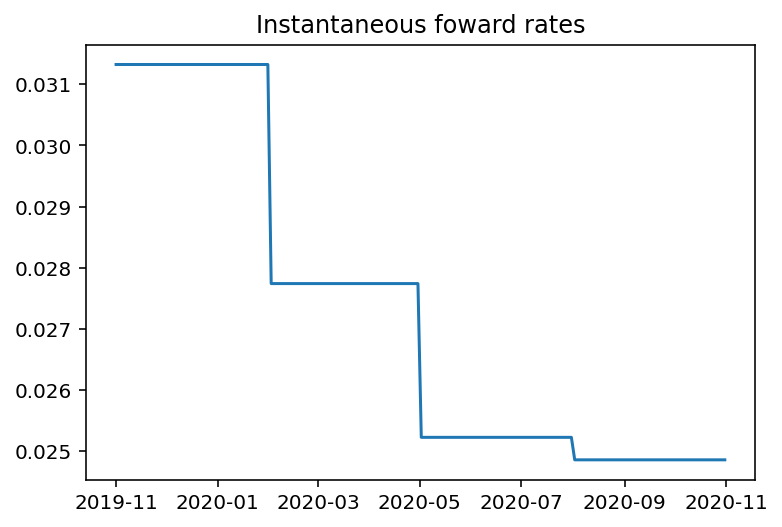

In [12]:
sample_dates = [ql.Date(date) for date in range(end_dates[0].serialNumber(), end_dates[-1].serialNumber())]
sample_fwds  = [fwd_curve.forwardRate(date, date, ql.Actual360(), ql.Continuous).rate() for date in sample_dates]


plt.title('Instantaneous foward rates')
plt.plot([date.to_date() for date in sample_dates], sample_fwds);